In [65]:
# The Data is part of the Kaggle Competition: https://www.kaggle.com/c/sf-crime/data

# 1 Imports and Loading the Data

In [126]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import tensorflow as tf

df_train = pd.read_csv("data/sf-crime/train.csv")
df_test = pd.read_csv("data/sf-crime/test.csv")

print(df_train.describe())
df_train.head()

                   X              Y
count  878049.000000  878049.000000
mean     -122.422616      37.771020
std         0.030354       0.456893
min      -122.513642      37.707879
25%      -122.432952      37.752427
50%      -122.416420      37.775421
75%      -122.406959      37.784369
max      -120.500000      90.000000


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [88]:
print(*df_train['Address'][0:100])

OAK ST / LAGUNA ST OAK ST / LAGUNA ST VANNESS AV / GREENWICH ST 1500 Block of LOMBARD ST 100 Block of BRODERICK ST 0 Block of TEDDY AV AVALON AV / PERU AV KIRKWOOD AV / DONAHUE ST 600 Block of 47TH AV JEFFERSON ST / LEAVENWORTH ST JEFFERSON ST / LEAVENWORTH ST 0 Block of ESCOLTA WY TURK ST / JONES ST FILLMORE ST / GEARY BL 200 Block of WILLIAMS AV 0 Block of MENDELL ST EDDY ST / JONES ST GODEUS ST / MISSION ST MENDELL ST / HUDSON AV 100 Block of JONES ST 200 Block of EVELYN WY 1600 Block of VALENCIA ST 100 Block of JONES ST 100 Block of JONES ST FILLMORE ST / LOMBARD ST 300 Block of OFARRELL ST 2000 Block of BUSH ST 500 Block of COLLEGE AV 19TH AV / SANTIAGO ST 2000 Block of 41ST AV 1300 Block of WEBSTER ST 400 Block of CASTRO ST 1500 Block of FILLMORE ST 1600 Block of WEBSTER ST 1600 Block of WEBSTER ST KING ST / 3RD ST VALLEJO ST / BUCHANAN ST CALIFORNIA ST / BUCHANAN ST 1400 Block of HOLLOWAY AV 0 Block of WINDING WY 700 Block of MARKET ST 1600 Block of MARKET ST 0 Block of STOCKTON

# 2 Data Preprocessing

In [55]:
# Histograms for each column
# nrows = df_train.shape[1]
# fig, ax = plt.subplots(nrows=nrows, sharex=False, figsize=(16, 10))
# fig.subplots_adjust(hspace=0.2, wspace=0.4)
# for i in range(nrows):
#         if i <= df_train.shape[1]-1:
#             print(df_train[columns[i]].describe())
#             y = df_train[columns[i]]
#             ax[i].hist(y, color='#039dfc', label=columns[i], bins='auto')
#             ax[i].set_title(columns[i])
# plt.show()

In [177]:
# Processing Function for Features
def cart2polar(x, y):
    dist = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return dist, phi

def preprocessFeatures(dfx):
    
    # Time Feature Engineering
    df = pd.get_dummies(dfx[['DayOfWeek' , 'PdDistrict']])
    # df['Timestamp'] = pd.to_datetime(df_train['Dates']).dt.date
    df['Hour_Min'] = pd.to_datetime(dfx['Dates']).dt.hour + pd.to_datetime(dfx['Dates']).dt.hour/60
    df['Day'] = pd.to_datetime(dfx['Dates']).dt.day
    df['Month'] = pd.to_datetime(dfx['Dates']).dt.month
    df['Year'] = pd.to_datetime(dfx['Dates']).dt.year

    month_one_hot_encoded = pd.get_dummies(pd.to_datetime(dfx['Dates']).dt.month, prefix='Month')
    df = pd.concat([df, month_one_hot_encoded], axis=1, join="inner")
    
    # Coordinates Feature Engineering
    df[['X', 'Y']] = dfx[['X', 'Y']]
    df['dist'], df['phi'] = cart2polar(df['X'], df['Y'])
    
    # Adress Feature Engineering

#     df['cross'] = dfx['Address'].str.split("/", n = 1)
#     df['Address_1'] = df['cross'].str[0]
#     print(df['cross'])
#     if len(df['cross'].str) > 0: 
#         df['Address_2'] = df['cross'].str[1]
#     dfx['streettype'] = dfx.loc[-2:,['Address']]  
    streettype_encoded = pd.get_dummies(dfx['streettype'], prefix='streettype')
    df = pd.concat([df, streettype_encoded], axis=1, join="inner")    
    
    return df

# Processing Function for Labels
def preprocessLabels(dfx):
    df = pd.DataFrame (columns = [])
    factor = pd.factorize(dfx['Category'])
    df['f_Category'] = factor[0]
    return df

# Remove Outliers
df_train_filtered = df_train[df_train['Y']<70]
# Create train_df & test_df
x_df = preprocessFeatures(df_train_filtered).copy()
y_df = preprocessLabels(df_train_filtered).copy()

# Split the data into x_train and y_train data sets
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, train_size=0.7, random_state=0)

<ipython-input-177-ecb8425991d2>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx['streettype'] = dfx.loc[-2:,['Address']]


In [162]:
x_train

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,...,Month_9,Month_10,Month_11,Month_12,X,Y,dist,phi,cross,Address_1
276998,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,-122.411988,37.785023,128.110900,2.842200,[300 Block of ELLIS ST],300 Block of ELLIS ST
81579,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,-122.500860,37.748470,128.185052,2.842677,[2000 Block of 42ND AV],2000 Block of 42ND AV
206676,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,-122.421748,37.762744,128.113657,2.842389,[600 Block of VALENCIA ST],600 Block of VALENCIA ST
732006,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,-122.410955,37.784140,128.109653,2.842204,"[TAYLOR ST , EDDY ST]",TAYLOR ST
796194,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-122.425825,37.791333,128.125982,2.842185,[1900 Block of GOUGH ST],1900 Block of GOUGH ST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,-122.405832,37.785745,128.105231,2.842180,"[MARKET ST , ELLIS ST]",MARKET ST
152315,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,-122.409854,37.783386,128.108378,2.842207,[0 Block of TURK ST],0 Block of TURK ST
117952,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,-122.411593,37.783053,128.109942,2.842214,[100 Block of TURK ST],100 Block of TURK ST
435829,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,-122.407244,37.786565,128.106822,2.842178,[100 Block of OFARRELL ST],100 Block of OFARRELL ST


# 3 Visualisierung

In [57]:
x = np.array(df_train_filtered['Category'])
print(np.unique(x))
print(np.unique(x).size)

['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS'
 'EMBEZZLEMENT' 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING'
 'FRAUD' 'GAMBLING' 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING'
 'MISSING PERSON' 'NON-CRIMINAL' 'OTHER OFFENSES'
 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION' 'RECOVERED VEHICLE' 'ROBBERY'
 'RUNAWAY' 'SECONDARY CODES' 'SEX OFFENSES FORCIBLE'
 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY' 'SUICIDE' 'SUSPICIOUS OCC'
 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT' 'WARRANTS' 'WEAPON LAWS']
39


C:\Users\Flo\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


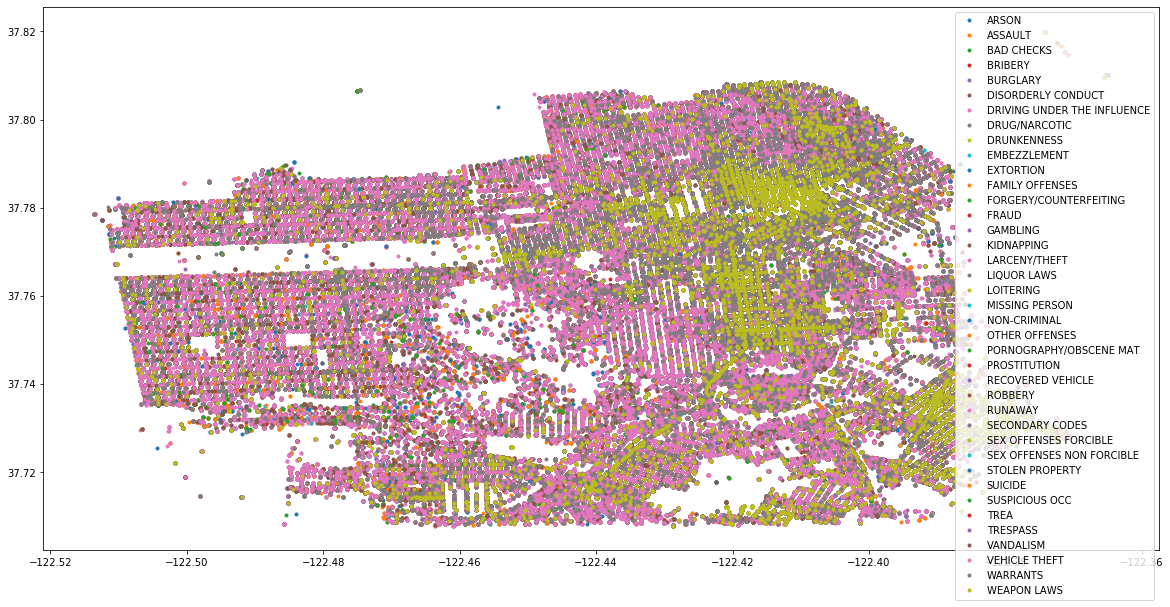

In [58]:
import mplleaflet
df_train_f = df_train_filtered

# ['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
# 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS'
# 'EMBEZZLEMENT' 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING'
# 'FRAUD' 'GAMBLING' 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING'
# 'MISSING PERSON' 'NON-CRIMINAL' 'OTHER OFFENSES'
# 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION' 'RECOVERED VEHICLE' 'ROBBERY'
# 'RUNAWAY' 'SECONDARY CODES' 'SEX OFFENSES FORCIBLE'
# 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY' 'SUICIDE' 'SUSPICIOUS OCC'
# 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT' 'WARRANTS' 'WEAPON LAWS']

#df_train_f = df_train_filtered[df_train_filtered['Category'].isin(['BRIBERY', 'DRUNKENNESS', 'KIDNAPPING', 'FRAUD', 'SUICIDE'])]
groups = df_train_f.groupby('Category')

# Plot
fig, ax = plt.subplots(sharex=False, figsize=(20, 10))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['X'], group['Y'], marker='.', linestyle='', label=name)
ax.legend()

#mplleaflet.show(fig = ax.figure)

Text(0, 0.5, 'Labels')

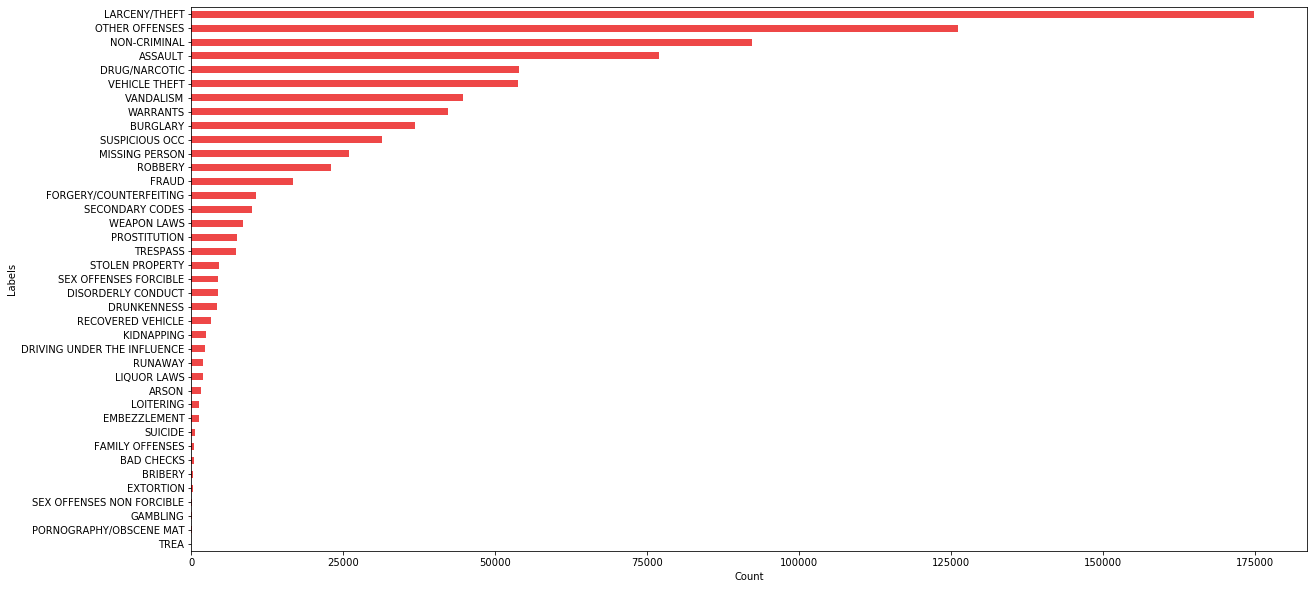

In [59]:
# Visualizing Category Distribution
fig, ax = plt.subplots(sharex=False, figsize=(20, 10))
cat_ordered = df_train_f['Category']
ax = cat_ordered.value_counts(sort=True,ascending=True).plot(kind='barh', color='#EE4747')
ax.set_xlabel('Count')
ax.set_ylabel('Labels')

# 4 Model Training

# 4 A: Scitkit-Learn Random Forest Classifier

In [60]:
# # Train a single random forest classifier - parameters are a best guess
# clf = RandomForestClassifier(max_depth=30, random_state=0, n_estimators = 200, class_weight='balanced')
# clf.fit(x_train, y_train.values.ravel())
# y_pred = clf.predict(x_test)

# results_log = classification_report(y_test, y_pred)
# print(results_log)

# 4 B Tensorflow Boosted Tree Classifier

In [63]:
# feature_columns = x_train.copy()

# n_batches = 1
# est = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer=n_batches)

# # The model will stop training once the specified number of trees is built, not
# # based on the number of steps.
# est.train(x_train, max_steps=100)

In [64]:
# Random Search
import xgboost as xgb

label = pd.DataFrame(np.random.randint(2, size=len(x_train)))
dtrain = xgb.DMatrix(x_train, label=label)
label = pd.DataFrame(np.random.randint(2, size=len(x_test)))
dtest = xgb.DMatrix(x_test, label=label)

param = {'max_depth': 30, 'eta': 1, 'objective': 'multi:softmax', 'predictor': 'gpu_predictor', 'num_class': 39}
num_round = 100
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, evallist)

ypred = bst.predict(dtest)

results_log = classification_report(y_test, y_pred)
print(results_log)

[22:44:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	eval-mlogloss:0.69417	train-mlogloss:0.69414
[1]	eval-mlogloss:0.74303	train-mlogloss:0.61268
[2]	eval-mlogloss:0.78440	train-mlogloss:0.55076
[3]	eval-mlogloss:0.84655	train-mlogloss:0.45767
[4]	eval-mlogloss:0.86627	train-mlogloss:0.43385
[5]	eval-mlogloss:0.88374	train-mlogloss:0.41368
[6]	eval-mlogloss:0.91285	train-mlogloss:0.37791
[7]	eval-mlogloss:0.95091	train-mlogloss:0.33413
[8]	eval-mlogloss:0.97728	train-mlogloss:0.31043
[9]	eval-mlogloss:1.00772	train-mlogloss:0.28260
[10]	eval-mlogloss:1.03507	train-mlogloss:0.26038
[11]	eval-mlogloss:1.05979	train-mlogloss:0.24384
[12]	eval-mlogloss:1.07695	train-mlogloss:0.23295
[13]	eval-mlogloss:1.11205	train-mlogloss:0.21300


# 4 C Neural Network

In [73]:
x_train.shape[1]

37

In [79]:
# from keras.layers import Dense,Dropout
# from keras.models import Sequential

# batch_size=1000

# model=Sequential()
# model.add(Dense(x_train.shape[1], input_shape=(x_train.shape[1], )))
# model.add(Dense(128,activation='relu'))
# model.add(Dense(64,activation='relu'))
# model.add(Dense(64,activation='relu'))
# model.add(Dense(1,activation='softmax'))
# model.summary()
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# train=model.fit(x=x_train,y=y_train,batch_size=batch_size,epochs=10,verbose=2,validation_data=(x_test, y_test))

# plt.figure(figsize=(5,5))
# plt.plot(train.history['accuracy'],'r',label='Training accuracy')
# plt.plot(train.history['val_accuracy'],'b',label='Validation accuracy')
# plt.legend()

# 5 Model Testing